# National Flood Insurance Program Data for NYC
## Policies Sample Analysis

In [1]:
# importing libraries
import os
import glob
import numpy as np
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import seaborn as sns

plt.rcParams['savefig.facecolor'] = 'white'
%matplotlib inline

In [2]:
print('printing packages and versions:\n')

%reload_ext watermark
%watermark -v -p numpy,pandas,geopandas,matplotlib,seaborn

printing packages and versions:

Python implementation: CPython
Python version       : 3.8.13
IPython version      : 8.4.0

numpy     : 1.23.1
pandas    : 1.4.3
geopandas : 0.11.1
matplotlib: 3.5.2
seaborn   : 0.11.2



# NFIP Policies Data Dictionary
https://www.fema.gov/openfema-data-page/fima-nfip-redacted-policies-v2

# Read in Data

In [3]:
%%time

path = 'data/'
all_files = glob.glob(os.path.join(path, "policies-*.json"))

# concat all counties into one dataframe
df = pd.concat((pd.read_json(file) for file in all_files), ignore_index=True)
# reverse column order
df = df.loc[:, df.columns[::-1]]

# examine data
print('shape of data: {}'.format(df.shape))
df.head()

shape of data: (506278, 81)
CPU times: user 29.4 s, sys: 5.07 s, total: 34.4 s
Wall time: 34.7 s


,id,longitude,latitude,censusBlockGroupFips,censusTract,countyCode,reportedZipCode,reportedCity,propertyState,femaRegion,...,elevatedBuildingIndicator,contentsDeductibleCode,buildingDeductibleCode,crsClassCode,construction,condominiumCoverageTypeCode,cancellationDateOfFloodPolicy,basementEnclosureCrawlspaceType,baseFloodElevation,agricultureStructureIndicator
0,6cdba47d-1e40-4680-8ca5-f2f4a61cb174,-74.0,40.7,3.606101e+11,3.606101e+10,36061,10011,Currently Unavailable,NY,2.0,...,False,0,0,NaN,False,N,None,NaN,NaN,False
1,f07086ce-f925-431e-ab70-fe1d9ab4e653,-74.0,40.7,3.606101e+11,3.606101e+10,36061,10011,Currently Unavailable,NY,2.0,...,False,0,0,NaN,False,N,None,NaN,NaN,False
2,1ded539c-1bdd-4f20-bb3d-314a92a9f9f1,-74.0,40.7,3.606101e+11,3.606101e+10,36061,10012,Currently Unavailable,NY,2.0,...,False,0,0,NaN,False,N,None,2.0,NaN,False
3,b3eb3d0a-446d-4493-bcba-b48dabc701aa,-73.9,40.8,NaN,NaN,36061,,Currently Unavailable,MS,4.0,...,False,1,1,NaN,False,N,None,NaN,NaN,False
4,0b1069b8-6b2b-4cb1-9ecd-af9aa8bd2170,-74.0,40.7,3.606101e+11,3.606101e+10,36061,10001,Currently Unavailable,NY,2.0,...,False,1,0,NaN,False,N,None,2.0,NaN,False


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 506278 entries, 0 to 506277
Data columns (total 81 columns):
 #   Column                                  Non-Null Count   Dtype  
---  ------                                  --------------   -----  
 0   id                                      506278 non-null  object 
 1   longitude                               506278 non-null  float64
 2   latitude                                506278 non-null  float64
 3   censusBlockGroupFips                    503883 non-null  float64
 4   censusTract                             503883 non-null  float64
 5   countyCode                              506278 non-null  int64  
 6   reportedZipCode                         506278 non-null  object 
 7   reportedCity                            506278 non-null  object 
 8   propertyState                           506278 non-null  object 
 9   femaRegion                              506277 non-null  float64
 10  floodZoneCurrent                        3753

# Data Wrangling

In [5]:
# convert date fields to datetime
df['policyTerminationDate'] = pd.to_datetime(df['policyTerminationDate'], errors='coerce')
df['policyEffectiveDate'] = pd.to_datetime(df['policyEffectiveDate'], errors='coerce')
df['originalNBDate'] = pd.to_datetime(df['originalNBDate'], errors='coerce')

# extract year from datatime 
df['policyTerminationYear'] = df['policyTerminationDate'].dt.year
df['policyEffectiveYear'] = df['policyEffectiveDate'].dt.year
df['originalNBYear'] = df['originalNBDate'].dt.year

# preview columns
cols = [
    'policyTerminationDate', 'policyEffectiveDate', 'originalNBDate',
    'policyTerminationYear', 'policyEffectiveYear', 'originalNBYear'
]

df.loc[:, cols].head()

,policyTerminationDate,policyEffectiveDate,originalNBDate,policyTerminationYear,policyEffectiveYear,originalNBYear
0,2010-01-01 00:00:00+00:00,2009-01-01 00:00:00+00:00,2005-01-01 00:00:00+00:00,2010.0,2009.0,2005.0
1,2010-01-01 00:00:00+00:00,2009-01-01 00:00:00+00:00,2005-01-01 00:00:00+00:00,2010.0,2009.0,2005.0
2,2010-01-01 00:00:00+00:00,2009-01-01 00:00:00+00:00,2006-01-01 00:00:00+00:00,2010.0,2009.0,2006.0
3,2010-01-02 00:00:00+00:00,2009-01-02 00:00:00+00:00,1991-11-27 00:00:00+00:00,2010.0,2009.0,1991.0
4,2010-01-02 00:00:00+00:00,2009-01-02 00:00:00+00:00,2002-01-02 00:00:00+00:00,2010.0,2009.0,2002.0


In [6]:
# summarize column information
cols = ['policyTerminationDate', 'policyEffectiveDate', 'originalNBDate']

df.loc[:, cols].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 506278 entries, 0 to 506277
Data columns (total 3 columns):
 #   Column                 Non-Null Count   Dtype              
---  ------                 --------------   -----              
 0   policyTerminationDate  506277 non-null  datetime64[ns, UTC]
 1   policyEffectiveDate    506277 non-null  datetime64[ns, UTC]
 2   originalNBDate         506145 non-null  datetime64[ns, UTC]
dtypes: datetime64[ns, UTC](3)
memory usage: 11.6 MB


In [7]:
# count nulls 
cols = ['policyTerminationDate', 'policyEffectiveDate', 'originalNBDate']

df.loc[:, cols].isnull().sum()

policyTerminationDate      1
policyEffectiveDate        1
originalNBDate           133
dtype: int64

In [8]:
# return dataframe where specified columns are not null
condition = (
    (df['policyTerminationDate'].notnull())
     & (df['policyEffectiveDate'].notnull())
)

df = df.loc[condition].reset_index(drop=True)

df.head()

,id,longitude,latitude,censusBlockGroupFips,censusTract,countyCode,reportedZipCode,reportedCity,propertyState,femaRegion,...,crsClassCode,construction,condominiumCoverageTypeCode,cancellationDateOfFloodPolicy,basementEnclosureCrawlspaceType,baseFloodElevation,agricultureStructureIndicator,policyTerminationYear,policyEffectiveYear,originalNBYear
0,6cdba47d-1e40-4680-8ca5-f2f4a61cb174,-74.0,40.7,3.606101e+11,3.606101e+10,36061,10011,Currently Unavailable,NY,2.0,...,NaN,False,N,None,NaN,NaN,False,2010.0,2009.0,2005.0
1,f07086ce-f925-431e-ab70-fe1d9ab4e653,-74.0,40.7,3.606101e+11,3.606101e+10,36061,10011,Currently Unavailable,NY,2.0,...,NaN,False,N,None,NaN,NaN,False,2010.0,2009.0,2005.0
2,1ded539c-1bdd-4f20-bb3d-314a92a9f9f1,-74.0,40.7,3.606101e+11,3.606101e+10,36061,10012,Currently Unavailable,NY,2.0,...,NaN,False,N,None,2.0,NaN,False,2010.0,2009.0,2006.0
3,b3eb3d0a-446d-4493-bcba-b48dabc701aa,-73.9,40.8,NaN,NaN,36061,,Currently Unavailable,MS,4.0,...,NaN,False,N,None,NaN,NaN,False,2010.0,2009.0,1991.0
4,0b1069b8-6b2b-4cb1-9ecd-af9aa8bd2170,-74.0,40.7,3.606101e+11,3.606101e+10,36061,10001,Currently Unavailable,NY,2.0,...,NaN,False,N,None,2.0,NaN,False,2010.0,2009.0,2002.0


In [9]:
cols = ['policyTerminationDate', 'policyEffectiveDate']

df.loc[:, cols].isnull().sum()

policyTerminationDate    0
policyEffectiveDate      0
dtype: int64

In [10]:
# summary statistics
cols = ['policyTerminationDate', 'policyEffectiveDate', 'originalNBDate']

df.loc[:, cols].describe(datetime_is_numeric=True)

,policyTerminationDate,policyEffectiveDate,originalNBDate
count,506277,506277,506145
mean,2017-10-14 06:30:48.520079360+00:00,2016-10-11 17:31:36.368194304+00:00,2011-03-11 16:38:56.228551424+00:00
min,2010-01-01 00:00:00+00:00,2009-01-01 00:00:00+00:00,1950-10-10 00:00:00+00:00
25%,2014-07-05 00:00:00+00:00,2013-06-29 00:00:00+00:00,2007-07-14 00:00:00+00:00
50%,2017-10-06 00:00:00+00:00,2016-10-06 00:00:00+00:00,2012-07-07 00:00:00+00:00
75%,2021-04-10 00:00:00+00:00,2020-04-10 00:00:00+00:00,2014-11-16 00:00:00+00:00
max,2025-02-16 00:00:00+00:00,2024-02-16 00:00:00+00:00,2024-01-13 00:00:00+00:00


# Policies in Force

In [11]:
condition = (df['policyTerminationDate'] > '2023-11-30') & (df['policyEffectiveDate'] <= '2023-11-30')
pif_df = df.loc[condition].reset_index(drop=True)

as_of_date = pif_df['policyEffectiveDate'].max().strftime('%Y-%m-%d')
count = pif_df['policyCount'].sum()
coverage = (pif_df['totalBuildingInsuranceCoverage'] + pif_df['totalContentsInsuranceCoverage']).sum()
policy_fee = (pif_df['totalInsurancePremiumOfThePolicy'] + pif_df['federalPolicyFee']).sum()

# policy statistics
print('As of {}:\n------'.format(as_of_date))
print('Policies in Force: {:,}'.format(count))
print('Total Insurance Coverage: ${:,.0f}'.format(coverage))
print('Premium of Policy and Federal Policy Fee: ${:,.0f}'.format(policy_fee))

As of 2023-11-30:
------
Policies in Force: 59,370
Total Insurance Coverage: $16,420,691,000
Premium of Policy and Federal Policy Fee: $45,933,558


# Trends

In [12]:
# starting year of 2009
original_date = (
    df.loc[df['originalNBYear'] >= 2009]
    .groupby(by='originalNBYear')['policyCount']
    .sum()
    .reset_index()
    .astype({'originalNBYear':'int'})
    .sort_values(by='originalNBYear')
)

# preview data
original_date

,originalNBYear,policyCount
0,2009,33906
1,2010,37367
2,2011,37474
3,2012,32206
4,2013,135479
5,2014,59042
6,2015,41678
7,2016,28400
8,2017,20103
9,2018,16672


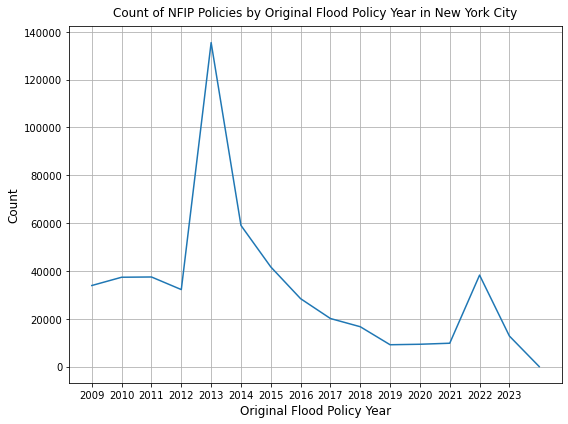

In [13]:
fig, ax = plt.subplots(figsize=(8, 6))

sns.lineplot(
    x=original_date['originalNBYear'],
    y=original_date['policyCount'],
    color='#1f77b4'
)

label = 'Count of NFIP Policies by Original Flood Policy Year in New York City'
plt.title(label, fontsize=12, pad=10)
plt.xlabel('Original Flood Policy Year', fontsize=12)
plt.ylabel('Count', fontsize=12)

xticks = np.arange(2009, 2024, 1)
ax.set_xticks(xticks)
plt.grid(True)

plt.tight_layout()
plt.savefig('figures/original-policies.png', bbox_inches='tight', dpi=250)

In [14]:
effective_date = (
    df.loc[df['policyEffectiveYear'] < 2024]
    .groupby(by='policyEffectiveYear')['policyCount']
    .sum()
    .reset_index()
    .astype({'policyEffectiveYear':'int'})
    .sort_values(by='policyEffectiveYear')
)

# preview data
effective_date

,policyEffectiveYear,policyCount
0,2009,37539
1,2010,38142
2,2011,39855
3,2012,41366
4,2013,56768
5,2014,56943
6,2015,57267
7,2016,57232
8,2017,55883
9,2018,54871


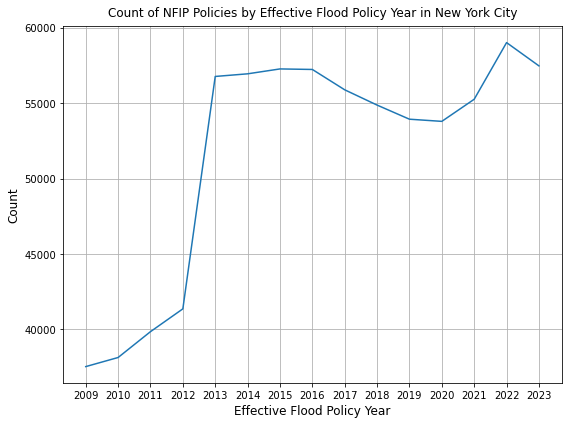

In [15]:
fig, ax = plt.subplots(figsize=(8, 6))

sns.lineplot(
    x=effective_date['policyEffectiveYear'],
    y=effective_date['policyCount'],
    color='#1f77b4'
)

label = 'Count of NFIP Policies by Effective Flood Policy Year in New York City'
plt.title(label, fontsize=12, pad=10)
plt.xlabel('Effective Flood Policy Year', fontsize=12)
plt.ylabel('Count', fontsize=12)

xticks = np.arange(2009, 2024, 1)
ax.set_xticks(xticks)
plt.grid(True)

plt.tight_layout()
plt.savefig('figures/effective-policies.png', bbox_inches='tight', dpi=250)

In [16]:
# total insurance coverage in billions
df['totalInsuranceCoverageB'] = (
    (df['totalBuildingInsuranceCoverage'] + df['totalContentsInsuranceCoverage']) / 1_000_000_000
)

total_coverage = (
    df.loc[df['policyEffectiveYear'] < 2024]
    .groupby(by='policyEffectiveYear')['totalInsuranceCoverageB']
    .sum()
    .reset_index()
    .astype({'policyEffectiveYear':'int'})
    .sort_values(by='policyEffectiveYear')
)

# preview data
total_coverage

,policyEffectiveYear,totalInsuranceCoverageB
0,2009,8.193513
1,2010,8.665323
2,2011,9.152814
3,2012,9.800809
4,2013,14.163300
5,2014,14.976931
6,2015,15.460696
7,2016,15.675451
8,2017,15.484719
9,2018,15.263786


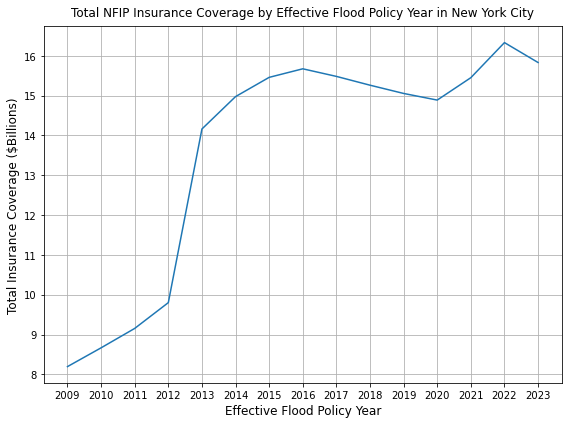

In [17]:
fig, ax = plt.subplots(figsize=(8, 6))

sns.lineplot(
    x=total_coverage['policyEffectiveYear'],
    y=total_coverage['totalInsuranceCoverageB'],
    color='#1f77b4'
)

label = 'Total NFIP Insurance Coverage by Effective Flood Policy Year in New York City'
plt.title(label, fontsize=12, pad=10)
plt.xlabel('Effective Flood Policy Year', fontsize=12)
plt.ylabel('Total Insurance Coverage ($Billions)', fontsize=12)

xticks = np.arange(2009, 2024, 1)
ax.set_xticks(xticks)
plt.grid(True)

plt.tight_layout()
plt.savefig('figures/total-coverage.png', bbox_inches='tight', dpi=250)

In [18]:
# premium and policy fees in millions
df['totalPremiumPolicyFeeM'] = (
    (df['totalInsurancePremiumOfThePolicy'] + df['federalPolicyFee']) / 1_000_000
)

total_policy_fee = (
    df.loc[df['policyEffectiveYear'] < 2024]
    .groupby(by='policyEffectiveYear')['totalPremiumPolicyFeeM']
    .sum()
    .reset_index()
    .astype({'policyEffectiveYear':'int'})
    .sort_values(by='policyEffectiveYear')
)

# preview data
total_policy_fee

,policyEffectiveYear,totalPremiumPolicyFeeM
0,2009,28.378794
1,2010,30.970685
2,2011,33.251425
3,2012,37.585601
4,2013,53.444978
5,2014,55.038439
6,2015,55.823127
7,2016,57.681163
8,2017,58.193313
9,2018,58.505415


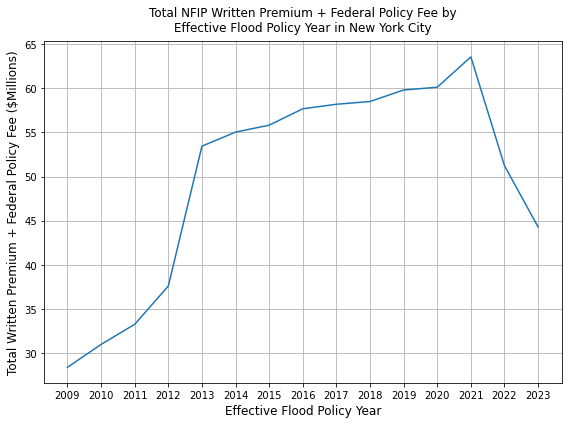

In [19]:
fig, ax = plt.subplots(figsize=(8, 6))

sns.lineplot(
    x=total_policy_fee['policyEffectiveYear'],
    y=total_policy_fee['totalPremiumPolicyFeeM'],
    color='#1f77b4'
)

label = 'Total NFIP Written Premium + Federal Policy Fee by\n\
Effective Flood Policy Year in New York City'
plt.title(label, fontsize=12, pad=10)
plt.xlabel('Effective Flood Policy Year', fontsize=12)
plt.ylabel('Total Written Premium + Federal Policy Fee ($Millions)', fontsize=12)

xticks = np.arange(2009, 2024, 1)
ax.set_xticks(xticks)
plt.grid(True)

plt.tight_layout()
plt.savefig('figures/total-policy-fee.png', bbox_inches='tight', dpi=250)